## Hyperparameter Tuning

The hyperparameters in deep learning to tune are 
- the number of neurons
- activation function
- optimiser
- learning rate
- batch size
- epochs 
- number of layers.


Reference: 
- https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/

### TODO: SOLVE THE ISSUE WITH HOW BIG THIS MODEL IS BECAUSE CANNOT RUN WITHOUT CUDA OUT OF MEMORY; MACBOOK ALSO WILL HANG

In [1]:
from typing import List, Optional, Callable
import os
import sys
from tqdm.auto import tqdm
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms
from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights

from ray import tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler

# determine the project root - required to import DataHandler from utils folder
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# configuring log file
log_dir = os.path.join(project_root, "logs")
os.makedirs(log_dir, exist_ok=True)
log_filename = os.path.join(log_dir, "efficientnetb5_dinov2_training_log.txt") #NOTE: specify based on model training

logging.basicConfig(
    filename=log_filename,
    filemode="w",  #NOTE: previous logs would be overwritten
    format="%(asctime)s %(levelname)s: %(message)s",
    level=logging.INFO
)

MODEL_SAVE_DIR = os.path.join(project_root, "models", "efficientnetb5_dinov2")
os.makedirs(MODEL_SAVE_DIR, exist_ok=True) 

RESULTS_SAVE_DIR = os.path.join(project_root, "results", "efficientnetb5_dinov2")
os.makedirs(RESULTS_SAVE_DIR, exist_ok=True) 

from utils.DataHandler import download_dataset, create_full_data_loaders, create_tuning_data_loaders

In [2]:
def get_device():
    if torch.cuda.is_available():
        print("Using device: CUDA (GPU)")
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        print("Using device: MPS (Apple Silicon GPU)")
        os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
        return torch.device("mps")
    else:
        print("Using device: CPU")
        return torch.device("cpu")

device = get_device()

Using device: CUDA (GPU)


## Data Download
This is adapted from SeparatingData.ipynb
Download the processed dataset from Google Drive if yet to.

In [3]:
DATA_DIR = "../input/final_split_15Apr2025"
ZIP_URL = "https://drive.google.com/uc?id=1XhSO100qgRuLEyopfb7-4gBp0CRjZkfg"
ZIP_FILENAME = "../input/final_split_15Apr2025.zip"
ROOT_DIR = "../input"

download_dataset(DATA_DIR, ZIP_URL, ZIP_FILENAME, ROOT_DIR)

Dataset already exists at ../input/final_split_15Apr2025


## Subset Data Load
For faster hyperparameter tuning, use a subset of the dataset to find the most optimised set of hyperparameters.
Loads dataset from processed dataset which should have been split to train, test, eval.

In [4]:
SPLIT_DATASET = os.path.abspath("../input/final_split_15Apr2025")
BATCH_SIZE = 16

# Define data transformation 
# in this notebook, we are doing it for DINOv2, so we resize to ~224x224
transform = transforms.Compose([
    transforms.Resize((456, 456)),
    transforms.ToTensor(),
])

TRAIN_LOADER, VAL_LOADER, TEST_LOADER = create_tuning_data_loaders(
    dataset_root=SPLIT_DATASET,
    transform=transform,
    batch_size=BATCH_SIZE,
    subset_fraction=0.5,
    random_seed=42
)

Using pre-split datasets: train 8025, val 579, test 572
Created tuning data loaders with subset fraction: 0.5
Created subset datasets for hyperparameter tuning: train 4012, val 289, test 572
Class Distribution for Subset Training:
  angry     : 983
  happy     : 1039
  relaxed   : 1024
  sad       : 966
Class Distribution for Subset Validation:
  angry     : 71
  happy     : 75
  relaxed   : 74
  sad       : 69


## Full Data Load
When doing the entire training for the entire dataset (full dataset not used in hyperparameter tuning)

In [5]:
FULL_TRAIN_LOADER, FULL_VAL_LOADER, FULL_TEST_LOADER = create_full_data_loaders(
    dataset_root=SPLIT_DATASET,
    transform=transform,
    batch_size=BATCH_SIZE,
)

Using pre-split datasets: train 8025, val 579, test 572


## Model Specifications

DINOv2 Transfer Learning with Torch Hub:
- https://debuggercafe.com/dinov2-for-image-classification-fine-tuning-vs-transfer-learning/
- https://github.com/facebookresearch/dinov2/tree/e1277af2ba9496fbadf7aec6eba56e8d882d1e35

DINOv2 GitHub
- https://github.com/facebookresearch/dinov2/blob/e1277af2ba9496fbadf7aec6eba56e8d882d1e35/dinov2/models/vision_transformer.py 

In [6]:
# Squeeze-Excitation Block
class SqueezeExcitationBlock(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.interaction = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.interaction(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [7]:
class EfficientNetDINOv2(nn.Module):
    """Modified EfficientNetB5 with Squeeze and Extraction Blocks for feature extraction;
    then DINOv2 model on the dog emotion dataset
    with a configurable classification head for hyperparameter tuning, 
    i.e parameters you wish to tune need to be specified
    """
    
    def __init__(self,
                 num_classes: int = 4,
                 dropout: float = 0.2,
                 freeze_backbone: bool = False,
                 hidden_sizes: Optional[List[int]] = None,
                 activation: str = 'relu') -> None:
        """
        Args:
            num_classes (int): Number of output classes.
            dropout (float): Dropout rate to apply in the classifier.
            freeze_backbone (bool): If True, freeze the backbone layers.
            hidden_sizes (Optional[List[int]]): List of sizes for hidden layers in the classifier.
                If None, a single linear layer is used.
            activation (str): Activation function to use in the classifier ('relu', 'tanh', etc.).
        """
        super(EfficientNetDINOv2, self).__init__()

        # load efficientnetb5 backbone
        weights = EfficientNet_B5_Weights.DEFAULT
        self.backbone = efficientnet_b5(weights=weights).features

        # freeze backbone except for last 2 blocks
        for param in self.backbone.parameters():
            param.requires_grad = False
        for name, param in self.backbone.named_parameters():
            if "6" in name or "7" in name:
                param.requires_grad = False

        # SE block
        self.se = SqueezeExcitationBlock(2048)

        # project to match DINOv2 model
        self.project = nn.Conv2d(2048, 384, kernel_size=1)
        self.adapt_pool = nn.AdaptiveAvgPool2d((37,37))

        # load DINOv2 backbone from Torch Hub
        self.dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
        in_features = self.dino.embed_dim  # e.g.,  384 for vits14
        
        # freeze DINOv2
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        
        # Build the classifier based on the provided hidden_sizes
        layers = []
        input_dim = in_features #should be 384
        if hidden_sizes:
            for hidden_dim in hidden_sizes:
                layers.append(nn.Dropout(p=dropout))
                layers.append(nn.Linear(input_dim, hidden_dim))
                layers.append(self._get_activation(activation))
                input_dim = hidden_dim
            # final classification layer
            layers.append(nn.Dropout(p=dropout))
            layers.append(nn.Linear(input_dim, num_classes))
        else:
            # single linear layer if no hidden layers specified
            layers.append(nn.Dropout(p=dropout))
            layers.append(nn.Linear(input_dim, num_classes))
        
        self.classifier = nn.Sequential(*layers)
    
    def _get_activation(self, activation: str) -> Callable:
        """Returns an activation function based on the given string.

        Args:
            activation (str): Name of the activation function.

        Returns:
            Callable: Activation function module.
        """
        if activation.lower() == 'relu':
            return nn.ReLU()
        elif activation.lower() == 'leakyrelu':
            return nn.LeakyReLU()
        elif activation.lower() == 'gelu':
            return nn.GELU()
        elif activation.lower() == 'tanh':
            return nn.Tanh()
        elif activation.lower() == 'sigmoid':
            return nn.Sigmoid()
        else:
            raise ValueError(f"Unsupported activation function: {activation}")
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.backbone(x) # [B, 2048, H, W]
        x = self.se(x)
        x = self.project(x) # [B, 384, H, W]
        x = self.adapt_pool(x)  # [B, 384, 14, 14]

        # transformer expects image to the patch embedding layer, need to bypass
        # prepare tokens for DINOv2 transformer
        B, C, H, W = x.shape
        tokens = x.flatten(2).transpose(1, 2)  # [B,196,384]

        # add cls token and positional embedding if model has them
        cls_token = self.dino.cls_token.expand(B, -1, -1)
        tokens = torch.cat((cls_token, tokens), dim=1)
        tokens = tokens + self.dino.pos_embed

        # forward tokens through transformer blocks
        for block in self.dino.blocks:
            tokens = block(tokens)
        tokens = self.dino.norm(tokens)

        # use class token for downstream classification
        representation = tokens[:, 0] # [B, 384]
        out = self.classifier(representation)
        return out

In [8]:
print(f"Using device: {device}")
model = EfficientNetDINOv2(num_classes=4, dropout=0.3, freeze_backbone=True, hidden_sizes=[256, 128], activation='relu').to(device)
print("Model instantiated:", model.__class__.__name__)
print(model)

Using device: cuda


Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Model instantiated: EfficientNetDINOv2
EfficientNetDINOv2(
  (backbone): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmo

## Hyperparameter Tuning
This is the part where you write the training function and load it to the ray tune scheduler.
For this execution, ASHAscheduler is used with Optuna for bayesian optimisation techniques - which should be using the default Tree-Structured Parzen Estimator.
If many parameters, this is would be more efficient than grid search and random search.

References:
- https://docs.ray.io/en/latest/tune/examples/includes/async_hyperband_example.html
- https://docs.ray.io/en/latest/tune/examples/tune-pytorch-cifar.html 
- https://docs.ray.io/en/latest/tune/examples/includes/mnist_pytorch.html
- https://docs.ray.io/en/latest/tune/api/suggestion.html

In [9]:
CHECKPOINT_DIR = os.path.abspath("../models/hyptune/efficientnetb5_dinov2")
def train_model( config, device=device, checkpoint_dir=CHECKPOINT_DIR, data_dir=None):
    """Training function for Ray Tune hyperparameter tuning.

    This function instantiates the model with hyperparameters
    specified in the config dictionary, trains the model on the global TRAIN_LOADER,
    evaluates on VAL_LOADER, and reports the validation loss to Ray Tune.

    Args:
        config (dict): Hyperparameter configuration. Expected keys include:
            - lr (float): Learning rate.
            - weight_decay (float): Weight decay for the optimizer.
            - dropout (float): Dropout rate for the classifier.
            - hidden_sizes (list or None): List of hidden layer sizes in the classifier.
            - activation (str): Activation function to use ('relu', 'tanh', etc.).
            - freeze_backbone (bool): Whether to freeze the model backbone.
            - num_epochs (int): Number of training epochs.
            - optimiser (callable, optional): Optimiser class. Default is optim.Adam.
            - criterion (callable, optional): Loss function instance. Default is nn.CrossEntropyLoss().
        checkpoint_dir (str, optional): Directory for checkpointing (if applicable).
        data_dir (str, optional): Not used here; included for compatibility.
    """
    if checkpoint_dir:
        os.makedirs(checkpoint_dir, exist_ok=True)
        print(f"Checkpoint Folder exists")
        
    # instantiate model with hyperparameters from config
    model = EfficientNetDINOv2(
        num_classes=4,
        dropout=config.get("dropout", 0.3),
        freeze_backbone=config.get("freeze_backbone", True),
        hidden_sizes=config.get("hidden_sizes", None),
        activation=config.get("activation", "relu")
    ).to(device)

    optimiser = config["optimiser"](model.parameters(), config["lr"], config["weight_decay"])
    criterion = config["criterion"]()

    num_epochs = config.get("num_epochs", 2)  # a low number for quick tuning, but update accordingly
        
    # training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in tqdm(TRAIN_LOADER, position=0, leave=True, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimiser.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimiser.step()
            running_loss += loss.item() * inputs.size(0)
            
        epoch_loss = running_loss / len(TRAIN_LOADER.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")
            
        # optionally, can checkpoint the model
        if checkpoint_dir:
            path = os.path.join(checkpoint_dir, f"checkpoint_{epoch}.pt")
            torch.save(model.state_dict(), path)
        
    # evaluation on the subset validation set
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in VAL_LOADER:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
        
    avg_val_loss = total_loss / len(VAL_LOADER.dataset)
    print(f"Validation Loss: {avg_val_loss:.4f}")
        
    # Report the metric to Ray Tune
    tune.report({"loss": avg_val_loss})

In [10]:
asha_scheduler = ASHAScheduler(
    time_attr='training_iteration',
    metric='loss',
    mode='min',
    max_t=100,           # max training iterations per trial
    grace_period=10,     # min iterations before stopping
    reduction_factor=3,
    brackets=1,
)

optuna_search = OptunaSearch(metric="loss", mode="min", seed=42)

# define search space in a config dictionary, i.e what are the values you want to try, this is just example of format
'''
config = {
    "lr": tune.loguniform(1e-5, 1e-2),
    "weight_decay": tune.loguniform(1e-6, 1e-2),
    "dropout": tune.uniform(0.1, 0.5),
    "hidden_sizes": tune.choice([[256, 128], [512, 256], None]),
    "activation": tune.choice(["relu", "tanh"]),
    "freeze_backbone": tune.choice([True, False]),
    "num_epochs": 2, 
    "optimiser": tune.choice([optim.Adam, optim.SGD]),
    "criterion": tune.choice([nn.CrossEntropyLoss, nn.NLLLoss]),
}
'''

# this is what i specified for the example because i am running on cpu
# config = {
#     "lr": tune.loguniform(1e-5, 1e-2),
#     "weight_decay": tune.loguniform(1e-6, 1e-2),
#     "dropout": tune.uniform(0.1, 0.5),
#     "freeze_backbone": tune.choice([True]),
#     "num_epochs": 2,
# }

# for dinov2 gpu
config = {
    "lr": tune.loguniform(1e-4, 1e-2),    
    "weight_decay": tune.loguniform(1e-5, 1e-3),
    "dropout": tune.uniform(0.3, 0.5),
    "hidden_sizes": None,
    "activation": tune.choice(["relu", "tanh", "sigmoid", "leakyrelu", "gelu"]),
    "freeze_backbone": True,
    "num_epochs": 10,
    "optimiser": tune.choice([
        lambda params, lr, wd: optim.Adam(params, lr=lr, weight_decay=wd),
        lambda params, lr, wd: optim.SGD(params, lr=lr, momentum=0.9, weight_decay=wd)
    ]),
    "criterion": tune.choice([
        lambda: nn.CrossEntropyLoss(),
    ])
}

def trial_dirname_creator(trial):
    # this is meant to create short and unique directory name for each trial bc else too long for windows
    # include a unique identifier (like trial.trial_id).
    return f"trial_{trial.trial_id}"

def trial_name_creator(trial):
    return f"t_{trial.trial_id}"

# tuner object
tuner = tune.Tuner(
    tune.with_resources(train_model, {"cpu": 4, "gpu": 1}), #NOTE: specify based on the device u using because by default it uses all, i.e if u have 4 cpus; it does 4 concurrent trials
    tune_config=tune.TuneConfig(
        scheduler=asha_scheduler,
        search_alg=optuna_search,
        num_samples=15,  # number of trials to run
        trial_dirname_creator=trial_dirname_creator,
        trial_name_creator=trial_name_creator, 
    ),
    run_config=tune.RunConfig(
        name="efficientnetb5_dinov2",
        storage_path="C:/ray_results/efficientnetb5_dinov2", #NOTE: not required for mac
        log_to_file=True,
        verbose=1,
        ),
    param_space=config,
)

results = tuner.fit()
print("Best config:", results.get_best_result(metric="loss", mode="min", filter_nan_and_inf=False).config)

(train_model pid=7944) Checkpoint Folder exists


(train_model pid=7944) Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main
(train_model pid=7944) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
(train_model pid=7944)   warnings.warn("xFormers is not available (SwiGLU)")
(train_model pid=7944) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
(train_model pid=7944)   warnings.warn("xFormers is not available (Attention)")
(train_model pid=7944) C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
(train_model pid=7944)   warnings.warn("xFormers is not available (Block)")
Epoch 1/10:  25%|██▍       | 62/251 [05:03<15:22,  4.88s/it]
2025-04-16 23:40:55,639	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. Th

RuntimeError: No best trial found for the given metric: loss. This means that no trial has reported this metric.

In [ ]:
best_config = results.get_best_result(metric="loss", mode="min").config
print("Full best config:", best_config)

Full best config: {'lr': 0.001217284708112243, 'weight_decay': 1.913588048769229e-05, 'dropout': 0.4604393961508079, 'hidden_sizes': [512, 256], 'activation': 'sigmoid', 'freeze_backbone': True, 'num_epochs': 10, 'optimiser': <function <lambda> at 0x000001EF82345480>, 'criterion': <function <lambda> at 0x000001EF823476D0>}


In [ ]:
final_model = EfficientNetDINOv2(
    num_classes=4,
    dropout=best_config["dropout"],
    freeze_backbone=best_config["freeze_backbone"],
    hidden_sizes=best_config["hidden_sizes"],
    activation=best_config["activation"]
)

Using cache found in C:\Users\Ning/.cache\torch\hub\facebookresearch_dinov2_main


In [ ]:
final_model = final_model.to(device)
logging.info("Model instantiated on device: %s", device)

In [ ]:
optimiser = best_config["optimiser"](final_model.parameters(), lr=best_config["lr"], wd=best_config["weight_decay"])
criterion = best_config["criterion"]()

In [ ]:
# early stopping parameters
patience = 5  # the number of epochs to wait to see if got improvements
best_val_loss = float('inf')
epochs_without_improvement = 0

num_epochs_full = 50

train_losses = []
val_losses = []

# training loop with early stopping
for epoch in range(num_epochs_full):
    final_model.train()
    running_loss = 0.0
    for inputs, targets in tqdm(FULL_TRAIN_LOADER, desc=f"Epoch {epoch+1}/{num_epochs_full}"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimiser.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimiser.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_train_loss = running_loss / len(FULL_TRAIN_LOADER.dataset)
    train_losses.append(epoch_train_loss)
    logging.info("Epoch %d: Training Loss: %.4f", epoch+1, epoch_train_loss)
    
    # evaluate on the validation set
    final_model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in FULL_VAL_LOADER:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = final_model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
    epoch_val_loss = running_val_loss / len(FULL_VAL_LOADER.dataset)
    val_losses.append(epoch_val_loss)
    logging.info("Epoch %d: Validation Loss: %.4f", epoch+1, epoch_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs_full} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
    
    # if no improvement then early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_without_improvement = 0
        # save the best model
        best_model_path = os.path.join(MODEL_SAVE_DIR, "efficientnetb5_dinov2_best_model.pt")
        torch.save(final_model.state_dict(), best_model_path)
        logging.info("Model saved to: %s",  {best_model_path})
        logging.info("Epoch %d: New best model saved.", epoch+1)
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print("Early stopping triggered.")
        logging.info("Early stopping triggered at epoch %d", epoch+1)
        break

Epoch 1/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 1/50 - Train Loss: 1.0109, Val Loss: 0.6509


Epoch 2/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 2/50 - Train Loss: 0.7727, Val Loss: 0.5810


Epoch 3/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 3/50 - Train Loss: 0.7448, Val Loss: 0.5458


Epoch 4/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 4/50 - Train Loss: 0.7062, Val Loss: 0.5460


Epoch 5/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 5/50 - Train Loss: 0.6755, Val Loss: 0.5282


Epoch 6/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 6/50 - Train Loss: 0.6447, Val Loss: 0.5332


Epoch 7/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 7/50 - Train Loss: 0.6220, Val Loss: 0.4993


Epoch 8/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 8/50 - Train Loss: 0.5949, Val Loss: 0.4998


Epoch 9/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 9/50 - Train Loss: 0.5893, Val Loss: 0.5035


Epoch 10/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 10/50 - Train Loss: 0.5607, Val Loss: 0.4735


Epoch 11/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 11/50 - Train Loss: 0.5439, Val Loss: 0.5036


Epoch 12/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 12/50 - Train Loss: 0.5224, Val Loss: 0.5049


Epoch 13/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 13/50 - Train Loss: 0.4934, Val Loss: 0.4707


Epoch 14/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 14/50 - Train Loss: 0.4951, Val Loss: 0.4914


Epoch 15/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 15/50 - Train Loss: 0.4945, Val Loss: 0.5149


Epoch 16/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 16/50 - Train Loss: 0.4722, Val Loss: 0.5056


Epoch 17/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 17/50 - Train Loss: 0.4518, Val Loss: 0.4781


Epoch 18/50:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch 18/50 - Train Loss: 0.4605, Val Loss: 0.4971
Early stopping triggered.


Test Loss: 0.4977, Test Accuracy: 83.39%


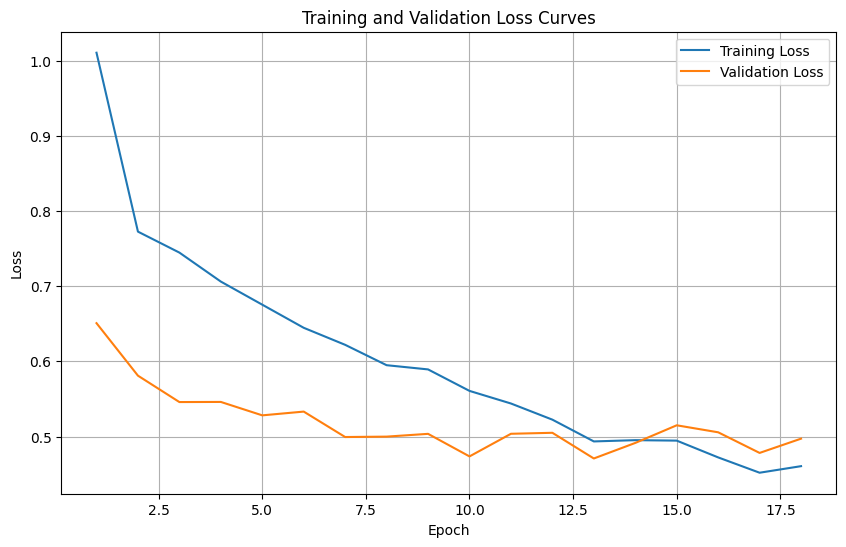


Classification Report:
               precision    recall  f1-score   support

       angry       0.87      0.83      0.85       140
       happy       0.83      0.86      0.85       148
     relaxed       0.78      0.80      0.79       146
         sad       0.86      0.84      0.85       138

    accuracy                           0.83       572
   macro avg       0.84      0.83      0.83       572
weighted avg       0.83      0.83      0.83       572



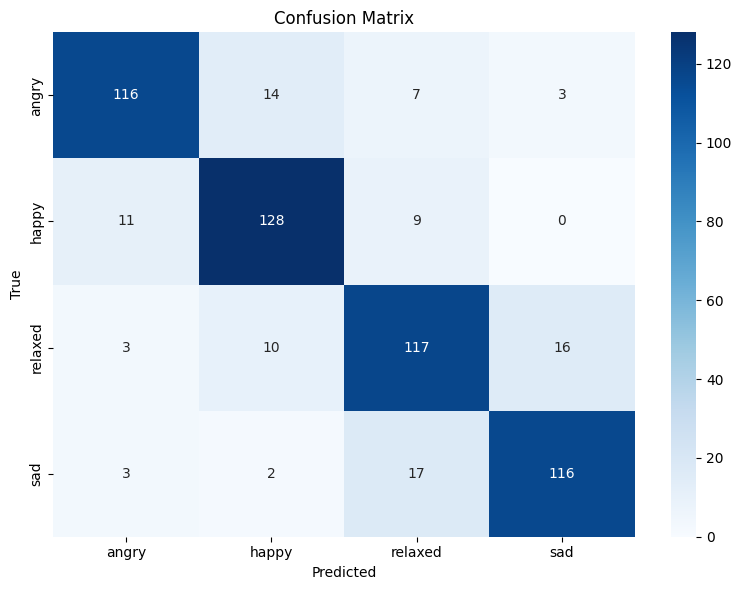

In [ ]:
# load best model from training
final_model.load_state_dict(torch.load(best_model_path))
final_model.to(device)
final_model.eval()

# initialise metrics
correct = 0
total = 0
test_loss = 0.0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in FULL_TEST_LOADER:
        images, labels = images.to(device), labels.to(device)
        outputs = final_model(images)
        # for test loss
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        # for accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy()) # move to cpu to ensure compatibility because numpy only operates on cpu
        all_labels.extend(labels.cpu().numpy())

test_loss = test_loss / len(FULL_TEST_LOADER.dataset)
test_accuracy = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
logging.info("Test Loss: %.4f, Test Accuracy: %.2f%%", test_loss, test_accuracy * 100)

# plotting training and validation loss curves
if 'train_losses' in globals() and 'val_losses' in globals():
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Training Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curves")
    plt.legend()
    plt.grid(True)
    loss_curve_path = os.path.join("..", "results", "efficientnetb5_dinov2", "loss_curves.png") #NOTE: specify by model name
    plt.savefig(loss_curve_path)
    plt.show()
    logging.info("Training and Validation Loss curves saved to %s", loss_curve_path)
else:
    logging.warning("train_losses and val_losses are not defined. Skipping loss curves plot.")

# generate and log classification report
class_names = FULL_TEST_LOADER.dataset.classes
report = classification_report(all_labels, all_preds, target_names=class_names)
print("\nClassification Report:\n", report)
logging.info("Classification Report:\n%s", report)

# generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# save confusion matrix as image
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()

conf_matrix_path = os.path.join("..", "results", "efficientnetb5_dinov2", "confusion_matrix.png") #NOTE: specify by model name
fig.savefig(conf_matrix_path)
plt.show(fig)

logging.info("Confusion matrix saved to: %s", conf_matrix_path)